In [105]:
%matplotlib inline
import gym
import tensorflow as tf
import keras

/home/aman/Documents/conda_gym/env_gym/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [106]:
from matplotlib import pyplot as plt
import numpy as np

In [107]:
from IPython.display import clear_output, display

In [108]:
env = gym.make('BreakoutDeterministic-v4')

In [109]:
def show_state(env, step=0, info=""):
    
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Atari Breakout")
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())


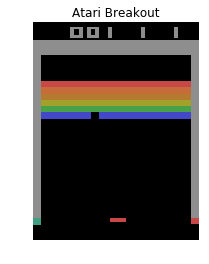

<Figure size 432x288 with 0 Axes>

In [110]:


# Reset it, returns the starting frame
frame = env.reset()


is_done = False
while not is_done:
    # Perform a random action, returns the new frame, reward and whether the game is over
    frame, reward, is_done, _ = env.step(env.action_space.sample())
    show_state(env.env)
    plt.clf()
  
    